# Imports

In [1]:
import sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.metrics import pairwise_distances
from PIL import Image
from sklearn.metrics import pairwise_distances
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

from DataSetFactory import DataSetFactory
from ClusterPlot import ClusterPlot

In [2]:
RANDOM_STATE = 42
# SAMPLE_SIZE=0.1

In [3]:
# ds = DataSetFactory.get_dataset('hapt', sample=SAMPLE_SIZE, random_state=RANDOM_STATE)
ds = DataSetFactory.get_dataset('hapt-train', random_state=RANDOM_STATE)

removing label 10 and 11 to keep only 10 classes to keep sns default pallet


In [4]:
X = ds.df[ds.feature_cols].values
y = ds.df[ds.label_col].values

In [5]:
X.shape

(7620, 561)

# Birch Threshold

In [6]:
def get_num_clusters_birch(ds, threshold):
    num_clusters = 0
    for label in ds.df[ds.label_col].unique():
        label_data = ds.df[ds.df[ds.label_col]==label][ds.feature_cols].values
        birch = Birch(threshold=threshold, branching_factor=2, n_clusters=None)
        birch.fit(label_data)
        num_clusters += birch.subcluster_centers_.shape[0]
    return num_clusters

def birch_threshold_plot(X, ds):
    dist_mat = pairwise_distances(X)
    print(dist_mat.shape)
    threshold_candidates = np.unique(dist_mat)
    print(threshold_candidates.shape)
    # for the sake of the experiment let's evaluate all of them
    thresholds_df = pd.DataFrame(threshold_candidates, columns=['threshold'])
    thresholds_df['num_clusters'] = np.nan
    thresholds_df['num_points'] = ds.df.shape[0]
    thresholds_df.hist(['threshold'])
    plt.show()
    # Filter only thresholds smaller than 1.5
#     thresholds_df_sample = thresholds_df[thresholds_df['threshold']<=0.2]
#     thresholds_df_sample = thresholds_df_sample.sample(n=200, random_state=RANDOM_STATE)
    thresholds_df_sample = thresholds_df.sample(n=200)
    
    thresholds_df_sample['num_clusters'] = thresholds_df_sample['threshold'].transform(lambda t: get_num_clusters_birch(ds, t))
    thresholds_df_sample['compression'] = thresholds_df_sample['num_points'] / thresholds_df_sample['num_clusters']
    
    sns.lineplot(x='threshold', y='compression', data=thresholds_df_sample)
    sns.lineplot(x='threshold', y='num_clusters', data=thresholds_df_sample)

(7767, 7767)
(31706928,)


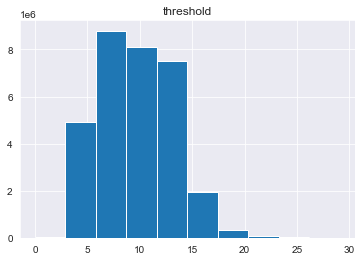

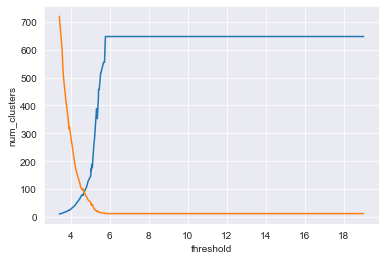

In [7]:
birch_threshold_plot(X, ds)

# Unsupervised UMAP

In [7]:
umap_cp = ClusterPlot(dim_reduction_algo='umap',
            reduce_all_points=True,
            n_iter=1, 
            batch_size=0,
            learning_rate=0.1,
            do_animation=False,
            dataset='HAPT',
            class_to_label=ds.class_to_label,
            show_fig=True,
            save_fig=True,
            random_state=RANDOM_STATE,
            show_anchors=False,
            supervised=False,
            show_points=True,
            show_inner_blobs=False,
            show_blobs=False,
            show_label_level_plots=False,
            show_anchor_level_plot=False,
            annotate_images=False,
            birch_threshold=4,
            umap_n_neighbors=50)
print(umap_cp)

ClusterPlot
addr:@264188
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=4
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=50
umap_min_dist=1
reduce_all_points=True
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function ClusterPlot.l_inf_loss at 0x00000254F247B5E8>
loss='Linf'
only_inter_relations=False
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={4: '4_STANDING', 6: '6_STAND_TO_SIT', 3: '3_SITTING', 7: '7_SIT_TO_STAND', 5: '5_LAYING', 9: '9_LIE_TO_SIT', 8: '8_SIT_TO_LIE', 0: '0_WALKING', 2: '2_WALKING_DOWNSTAIRS', 1: '1_WALKING_UPSTAIRS'}
random_state=42
n_jobs=None
dataset='HAPT'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=None
douglas_peucker_tolerance=0.6
smooth_iter=13
skip_p

finding intra class anchors using birch
UnSupervised Dim Reduction
Dim Reduction all points


C:\Users\omalkai\AppData\Local\Continuum\anaconda3_new\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\..\AppData\Local\Continuum\anaconda3_new\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^


C:\Users\omalkai\AppData\Local\Continuum\anaconda3_new\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\.

Starting iteration 1 loss = 1.0


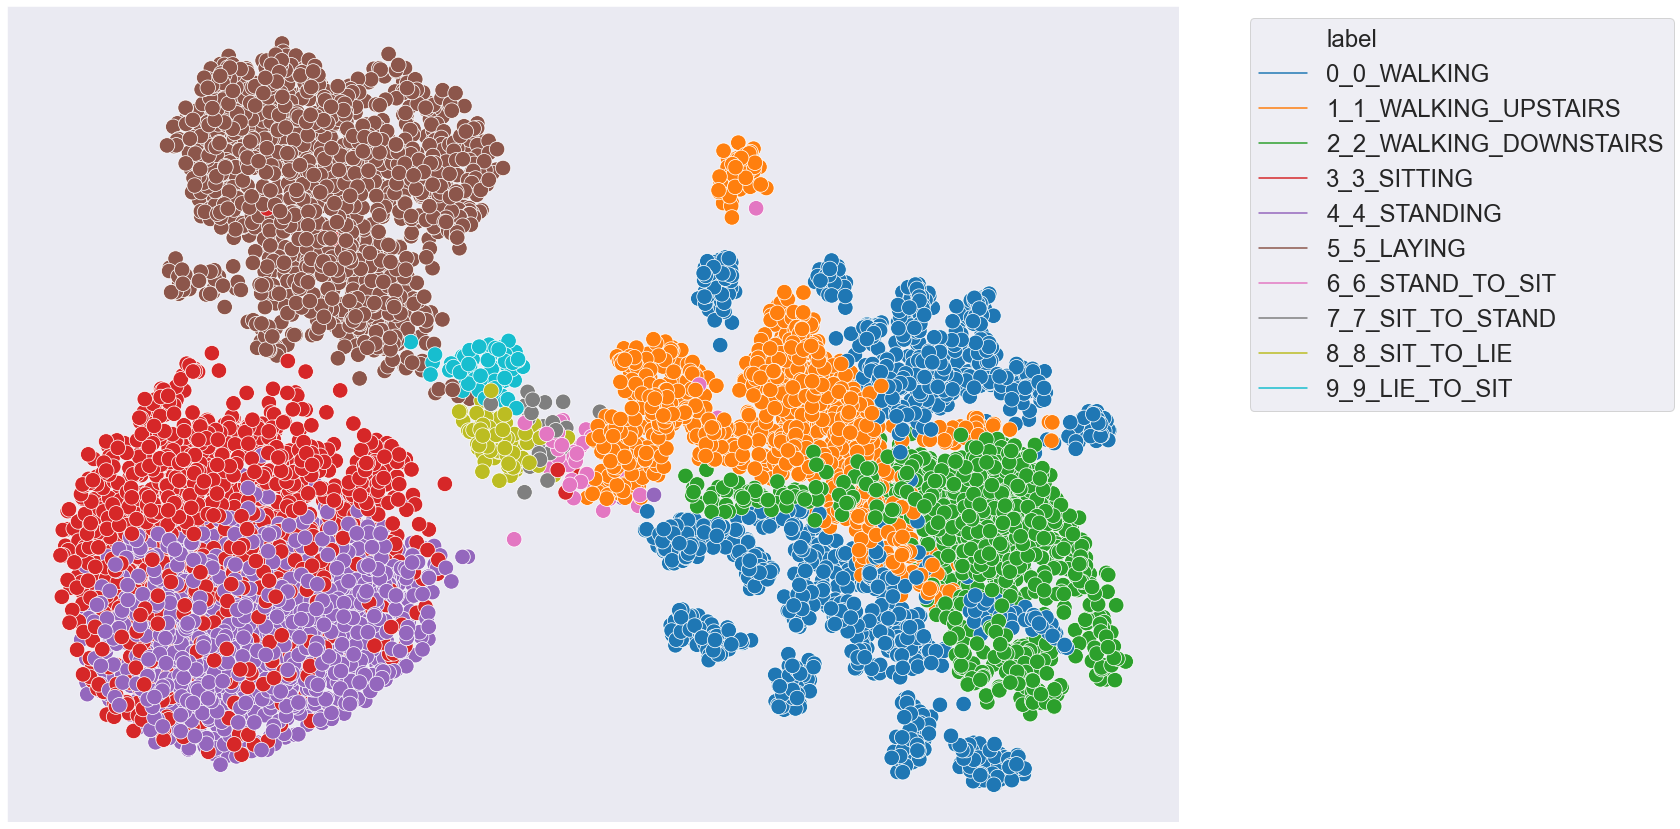

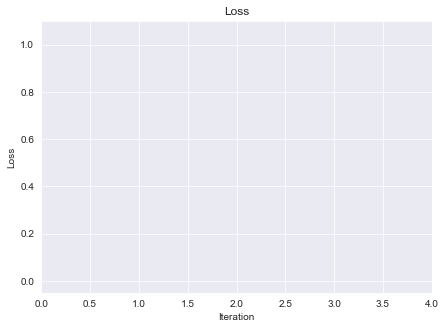

In [8]:
low_dim_umap = umap_cp.fit_transform(X, y)

# ClusterPlot

In [7]:
blobs_cp = ClusterPlot(reduce_all_points=False,
                  n_iter=1, 
                  batch_size=0,
                  learning_rate=0.1,
                  dataset='HAPT',
                  class_to_label=ds.class_to_label,
                  show_fig=True,
                  save_fig=True,
                  random_state=RANDOM_STATE,
                  show_anchors=False,
                  supervised=False,
                  show_points=False,
                  show_inner_blobs=False,
                  show_blobs=True,
                  show_label_level_plots=True,
                  show_anchor_level_plot=False,
                  save_fig_every=10,
                  annotate_images=False,
                  birch_threshold=4,
                  alpha=0,
                  douglas_peucker_tolerance=0.3,
                  smooth_iter=3,
                  magnitude_step=False,
                  only_inter_relations=False,
                  mask_relation_in_same_label=True,
                  vmax_overlap = 0.2)
print(blobs_cp)

ClusterPlot
addr:@d4e08
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=4
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
reduce_all_points=False
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function ClusterPlot.l_inf_loss at 0x0000015E7C1BB558>
loss='Linf'
only_inter_relations=False
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={4: '4_STANDING', 6: '6_STAND_TO_SIT', 3: '3_SITTING', 7: '7_SIT_TO_STAND', 5: '5_LAYING', 9: '9_LIE_TO_SIT', 8: '8_SIT_TO_LIE', 0: '0_WALKING', 2: '2_WALKING_DOWNSTAIRS', 1: '1_WALKING_UPSTAIRS'}
random_state=42
n_jobs=None
dataset='HAPT'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=0
douglas_peucker_tolerance=0.3
smooth_iter=3
skip_polyg

finding intra class anchors using birch
UnSupervised Dim Reduction
Dim Reduction only anchors
Dim Reduction only anchors - generate random points in low dim per anchor


100%|██████████████████████████████████████████████████████████████████████████████| 7817/7817 [06:57<00:00, 18.73it/s]


Starting iteration 1 loss = 0.8917874396135266


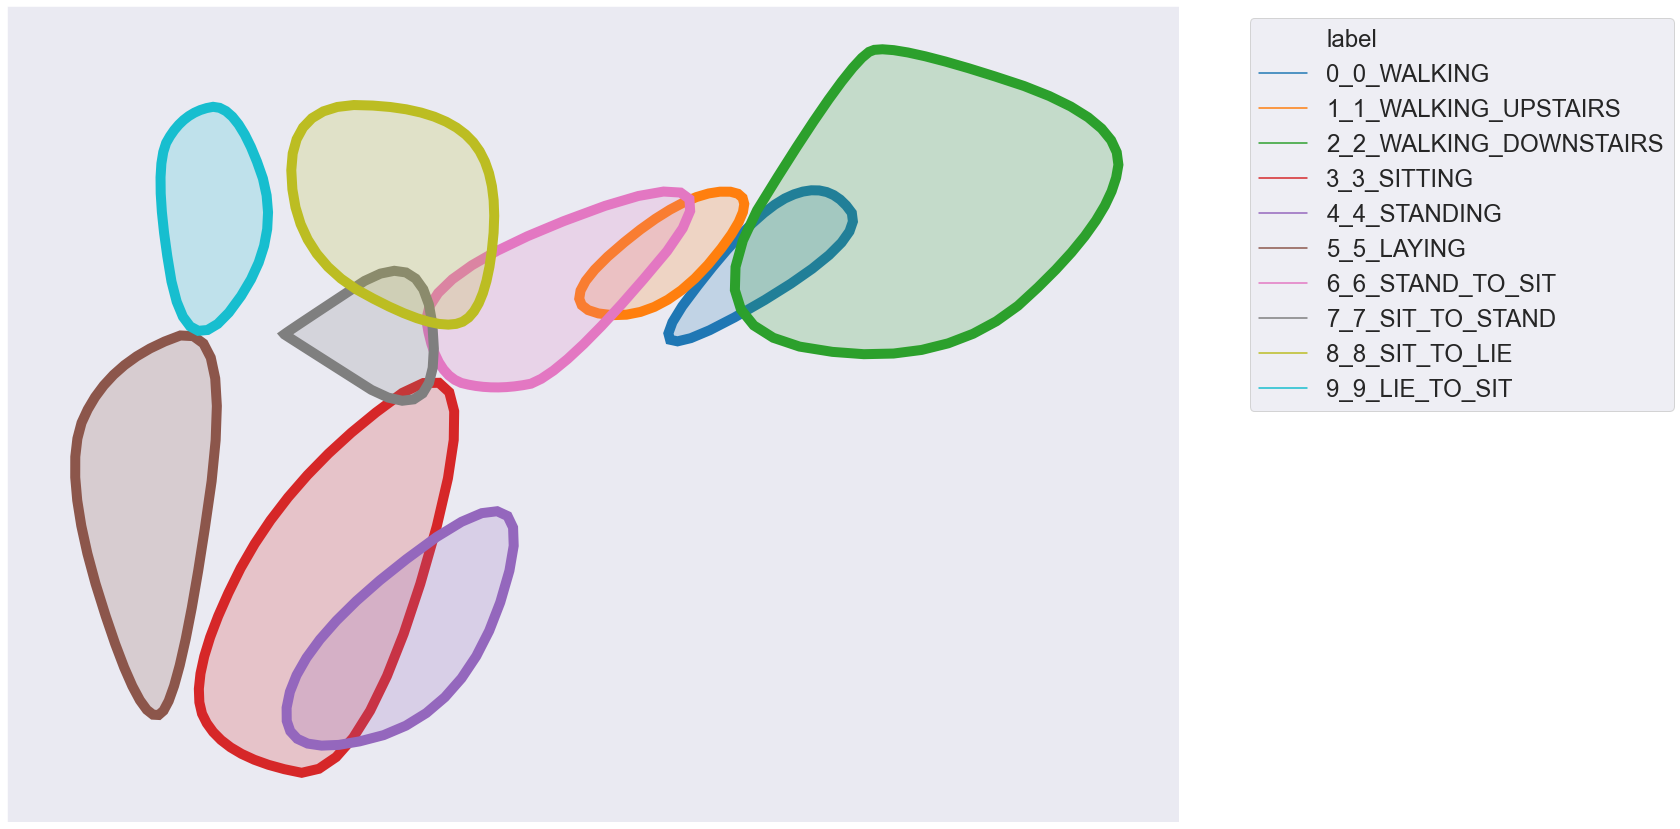

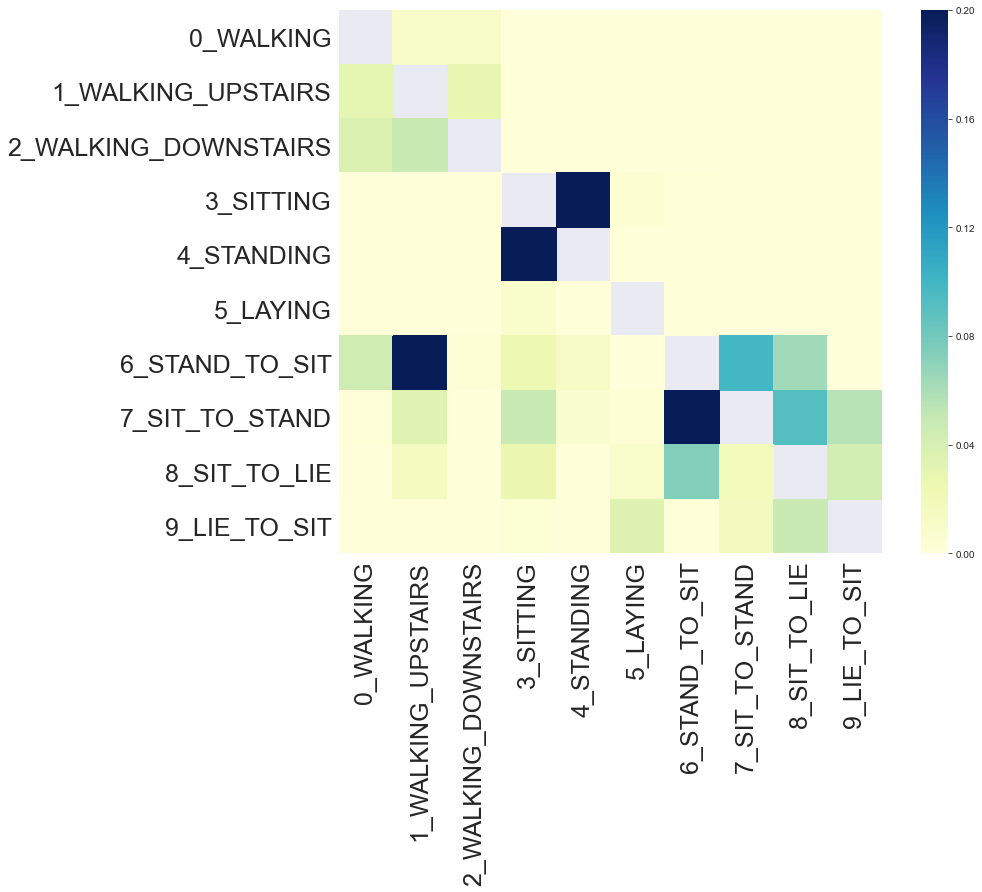

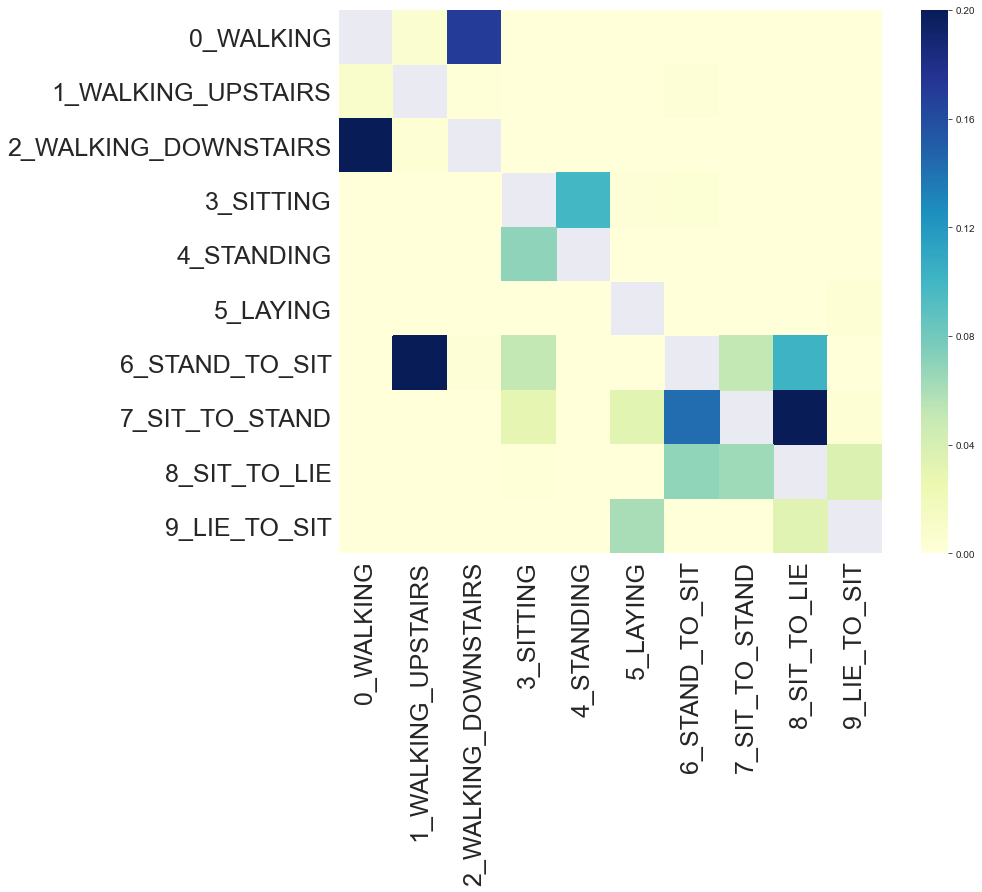

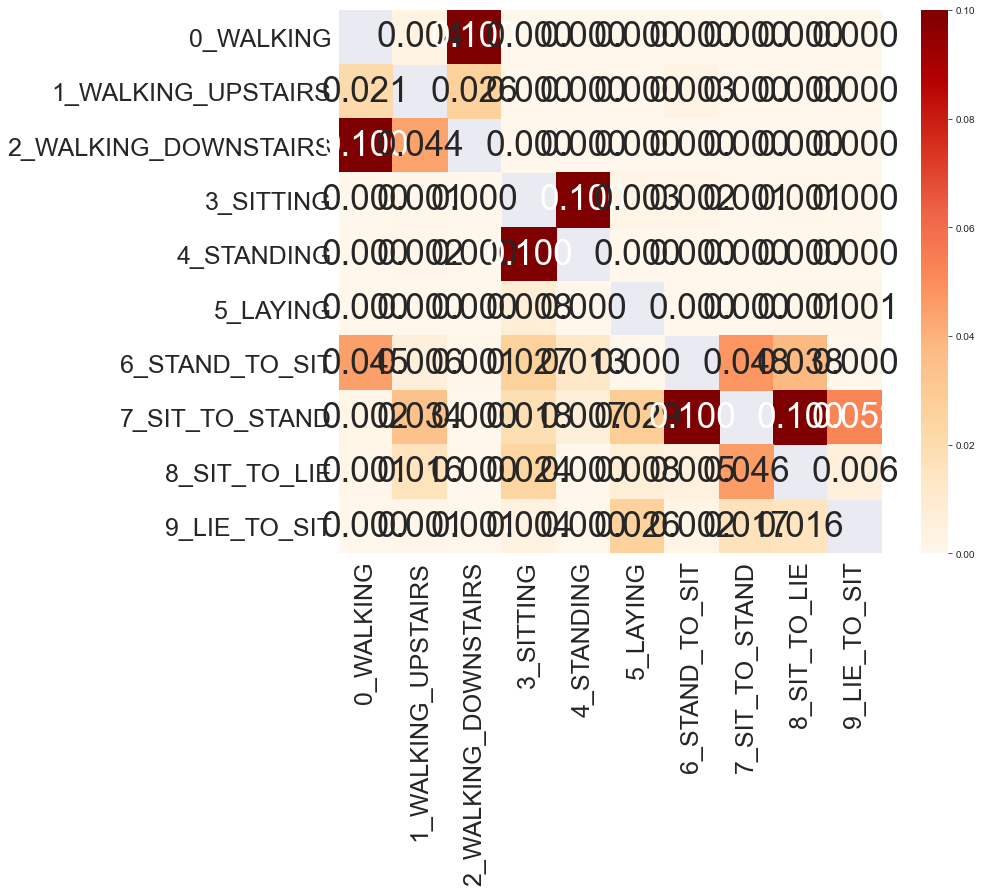

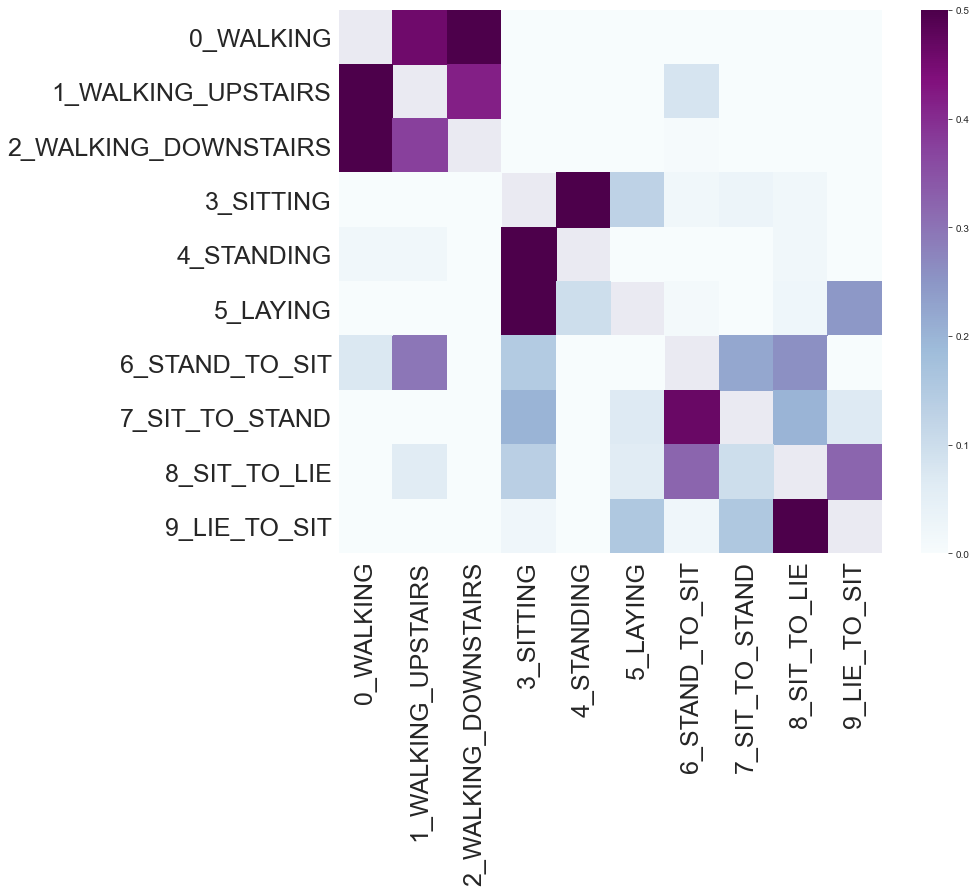

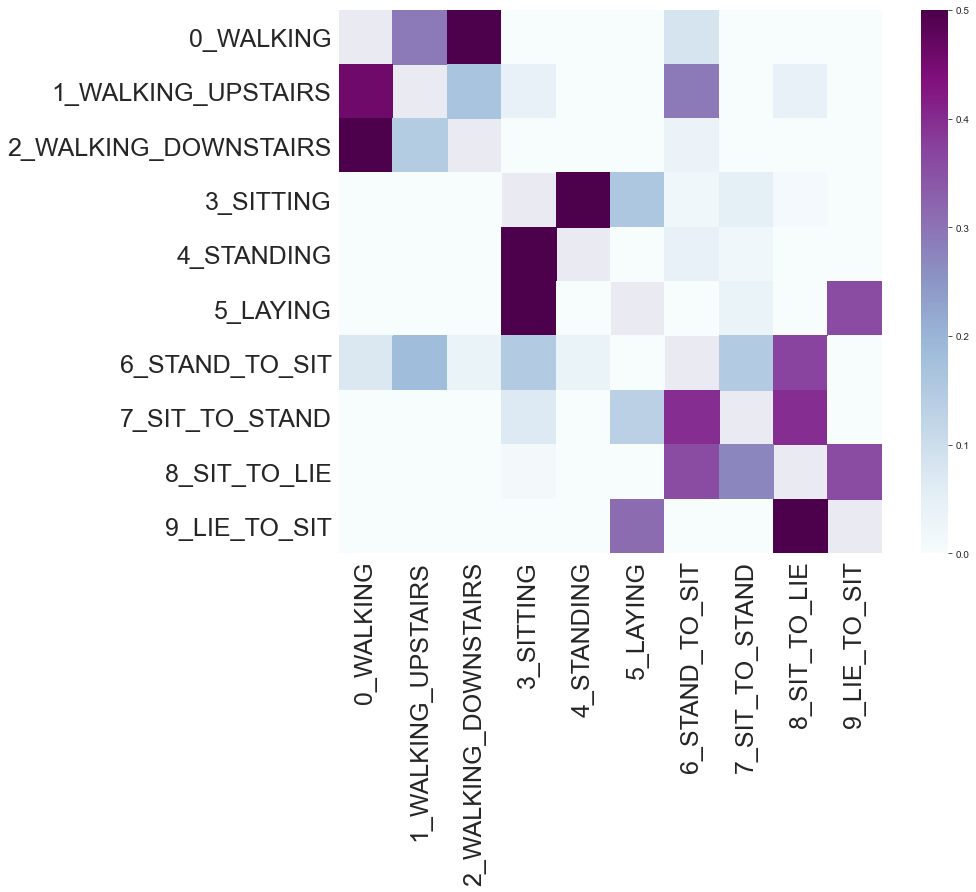

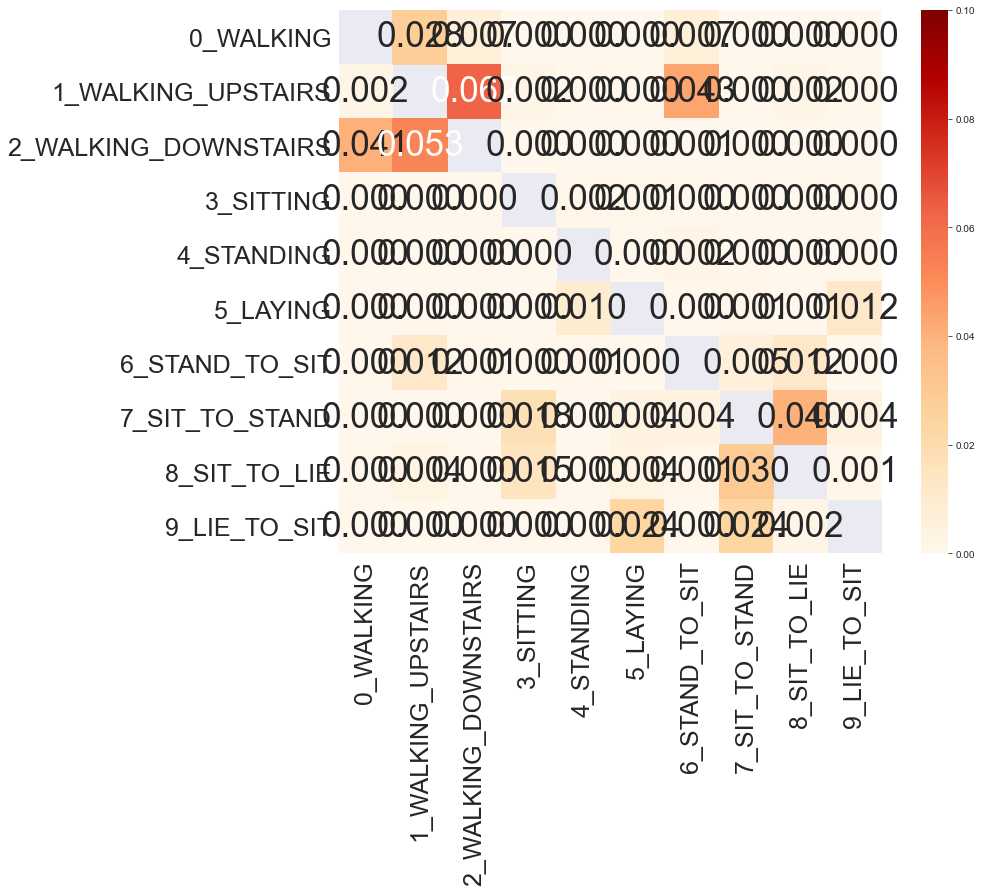

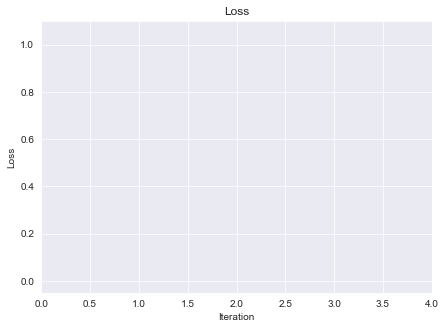

In [8]:
low_sim_blobs = blobs_cp.fit_transform(X, y)

# Classifier

In [6]:
ds_test = DataSetFactory.get_dataset('hapt-test', random_state=RANDOM_STATE)
X_test = ds_test.df[ds_test.feature_cols].values
y_test = ds_test.df[ds_test.label_col].values

removing label 10 and 11 to keep only 10 classes to keep sns default pallet


In [14]:
def plot_confusion_matrix(y_true, y_pred, ticks, cmap='Blues', normalize=True, annot=False):
    matrix = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    if normalize:
        matrix = matrix/matrix.sum(axis=1)[:,None]
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    vmax = 0.5
    g = sns.heatmap(matrix, ax=ax, annot=annot, fmt='.3f', square=True, cmap=cmap,
                    vmin=0, vmax=vmax, center=vmax/2,
                    xticklabels=[], yticklabels=ticks, annot_kws={"size": 16}, cbar=False)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    ax.set_ylabel('True Label', fontsize=15)
    ax.set_xlabel('Predicted Label', fontsize=15)
    ax.set_title(f'Accuracy: {acc:.2f}' , fontsize=15)
    plt.show()
    
    print(acc)

In [15]:
def train_predict_plot_mat(X_train, X_test, y_train, y_test, ds, model, clf_args=None, fit_args = None, test_size=0.2):
    if clf_args is None:
        clf_args = {}
    if fit_args is None:
        fit_args = {}
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)
    
    if model == 'knn':
        clf = KNeighborsClassifier(**clf_args)
    elif model == 'rf':
        clf = RandomForestClassifier(**clf_args)
    elif model == 'nn':
        
        np.random.seed(RANDOM_STATE)
        
        tf.random.set_seed(RANDOM_STATE)

        n_features = X_train.shape[1]
        # define model
        clf = Sequential()
        clf.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
        clf.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
        clf.add(Dense(len(np.unique(y_train)), activation='softmax'))
        # compile the model
        clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    clf.fit(X_train, y_train, **fit_args)
    y_predicted = clf.predict(X_test)
    
    if model == 'nn':
        y_predicted = np.argmax(y_predicted, axis=1)
    
    labels = [ds.class_to_label[i] for i in sorted(ds.class_to_label.keys())]
    plot_confusion_matrix(y_test, y_predicted, labels, annot=True)

Train on 7620 samples
Epoch 1/30
7620/7620 [==============================] - ETA: 3:06 - loss: 2.5202 - accuracy: 0.09 - ETA: 13s - loss: 2.1461 - accuracy: 0.1897 - ETA: 6s - loss: 2.0052 - accuracy: 0.199 - ETA: 4s - loss: 1.9153 - accuracy: 0.19 - ETA: 3s - loss: 1.8278 - accuracy: 0.23 - ETA: 2s - loss: 1.7692 - accuracy: 0.24 - ETA: 2s - loss: 1.7174 - accuracy: 0.26 - ETA: 1s - loss: 1.6638 - accuracy: 0.28 - ETA: 1s - loss: 1.6111 - accuracy: 0.30 - ETA: 1s - loss: 1.5776 - accuracy: 0.31 - ETA: 1s - loss: 1.5253 - accuracy: 0.34 - ETA: 1s - loss: 1.4764 - accuracy: 0.36 - ETA: 0s - loss: 1.4395 - accuracy: 0.38 - ETA: 0s - loss: 1.4111 - accuracy: 0.40 - ETA: 0s - loss: 1.3727 - accuracy: 0.41 - ETA: 0s - loss: 1.3388 - accuracy: 0.43 - ETA: 0s - loss: 1.3048 - accuracy: 0.44 - ETA: 0s - loss: 1.2804 - accuracy: 0.46 - ETA: 0s - loss: 1.2529 - accuracy: 0.47 - 2s 231us/sample - loss: 1.2497 - accuracy: 0.4782
Epoch 2/30
7620/7620 [==============================] - ETA: 1s - lo

7620/7620 [==============================] - ETA: 1s - loss: 0.1865 - accuracy: 0.90 - ETA: 0s - loss: 0.0581 - accuracy: 0.97 - ETA: 0s - loss: 0.0574 - accuracy: 0.97 - ETA: 1s - loss: 0.0639 - accuracy: 0.97 - ETA: 1s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0745 - accuracy: 0.97 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - ETA: 0s - loss: 0.0687 - accuracy: 0.97 - ETA: 0s - loss: 0.0686 - accuracy: 0.97 - ETA: 0s - loss: 0.0690 - accuracy: 0.97 - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0697 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - ETA: 0s - loss: 0.0697 - accuracy: 0.97 - ETA: 0s - loss: 0.0711 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - 1s 144us/sample - loss: 0.0704 - accuracy: 0.9739
Epoch 17/30
7620/7620 [

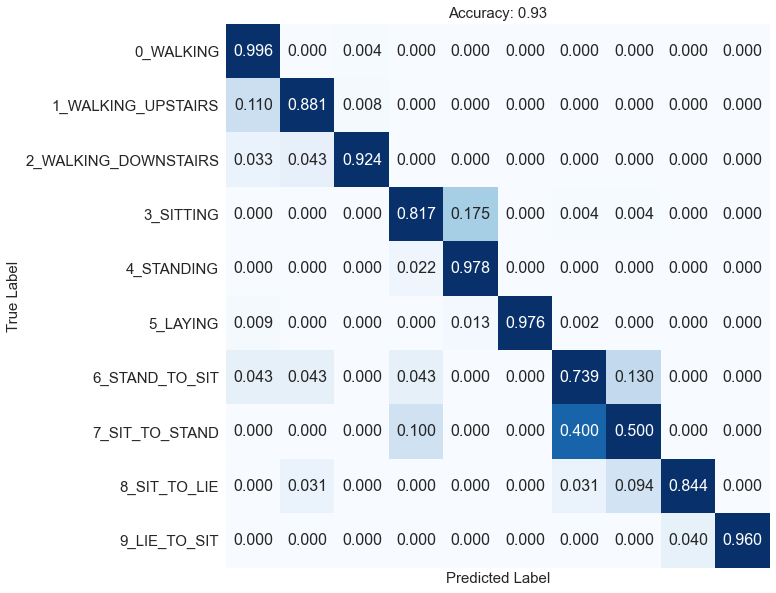

0.9270900842514582


In [16]:
train_predict_plot_mat(X, X_test, y, y_test, ds, 'nn', fit_args={'epochs':30, 'batch_size':32})